In [30]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [31]:
f = open("TestCase/10_10_2_4.txt")
fa = f.readlines()
tmp = fa[0].split()
N = int(tmp[0])
D = int(tmp[1])
a = int(tmp[2])
b = int(tmp[3])
day_off = np.zeros([N,D], dtype = int)
for i in range(1,len(fa)) :
    tmp = fa[i].split()
    for j in range(len(tmp) - 1) :
        m = int(tmp[j])
        day_off[i-1,m-1] = 1


In [32]:
class Individual :
    def __init__ (self, sol) :
        self.sol = sol
        self.fitness, bug = Fitness(sol)
        self.bug = bug

In [33]:
pop_size = 300
generation = 150

In [34]:
def hybrid (parent1 : Individual, parent2 : Individual)  :
    sol1 = np.zeros([N,D+1], dtype = int)
    sol2 = np.zeros([N,D+1], dtype = int)
    x = random.randint(0,D)
    for i in range(0,N) :
        for j in range(D) :
            if j <= x :
                sol1[i,j] = parent1.sol[i,j]
                sol2[i,j] = parent2.sol[i,j]
            else :
                sol1[i,j] = parent2.sol[i,j]
                sol2[i,j] = parent1.sol[i,j]
    child1 = Individual(sol1)
    child2 = Individual(sol2)
    return child1, child2

In [35]:
def mutate (parent : Individual) :
    sol = np.copy(parent.sol)
    for j in range(D) :
        if random.random() < max(0.1, 1/D) :
            i1 = random.randint(0,N-1)
            i2 = random.randint(0,N-1)
            while (sol[i2,j] == 0 and day_off[i1,j] == 1) or (sol[i1,j] == 0 and day_off[i2,j] == 1) or (sol[i2,j] == sol[i1,j]) :
                i1 = random.randint(0,N-1)
                i2 = random.randint(0,N-1)
            sol[i1,j], sol[i2,j] = sol[i2,j], sol[i1,j]
    child = Individual(sol)
    return child

In [36]:
def Fitness (sol) :
    bug = []
    constraint_day_off = 0
    for i in range(N) :
        for j in range(1, D) :
            if sol[i,j-1] == 4 and sol[i,j] > 0 :
                constraint_day_off += 1
                bug.append([i,j-1])
    num_night = np.zeros(N, dtype=int)
    for i in range(N) :
        for j in range(D) :
            if sol[i,j] == 4 :
                num_night[i] += 1
    max_night = max(num_night)
    return (100*constraint_day_off + max_night) , bug

In [37]:
def Local_Search (inv : Individual) -> Individual :
    sol = np.copy(inv.sol)
    if inv.fitness < 100 :
        num_night = np.zeros(N)
        for i in range(N) :
            for j in range(D) :
                if sol[i,j] == 4 : 
                    num_night[i] += 1
        i_1 = np.argmax(num_night)
        done = False
        for i in range(N) :
            if num_night[i_1] > num_night[i] + 1 :
                for j in range(D) :
                    if sol[i_1, j] == 4 and sol[i,j] < 4 and day_off[i,j] == 0 and sol[i,j+1] == 0 :
                        sol[i_1, j], sol[i,j] = sol[i,j], sol[i_1, j]
                        done = True
                        break
            if done == True :
                break
        new_inv = Individual(sol)
        return new_inv
                            
    bug = inv.bug
    t = random.choice(bug)

    i_1 = t[0]
    j_1 = t[1]
    done = False

    for i in range(N) :
        if sol[i,j_1] < 4 and sol[i,j_1 + 1] == 0 and day_off[i,j_1] == 0 :
            sol[i,j_1], sol[i_1,j_1] = 4, sol[i,j_1]
            done = True
            break
    if done == False :
        for i in range(N) :
            if sol[i,j_1 + 1] == 0 and day_off[i,j_1+1] == 0 and sol[i,j_1] < 4 :
                sol[i,j_1 + 1], sol[i_1, j_1 +1] = sol[i_1, j_1 +1], sol[i,j_1 + 1]

    new_inv = Individual(sol)
    return new_inv


In [38]:
population = []
for l in range(pop_size) :
    sol = np.zeros([N,D+1], dtype = int)
    for i in range(D) :
        candidate = []
        for j in range(N) :
            if day_off[j,i] == 0 :
                candidate.append(j)
        random.shuffle(candidate)
        for j in range(3*a) :
            sol[candidate[j],i] = 1
        for j in range(3*a, 4*a ) :
            sol[candidate[j],i] = 4
    inv = Individual(sol)
    population.append(inv)

In [39]:
def return_Fitness (inv) :
    return inv.fitness

In [40]:
record = []
for i in tqdm(range(generation)) :
    offspring = []
    for inv in population :
        new_inv = Local_Search(inv)
        offspring.append(new_inv)
    population.clear()
    population += offspring
    random.shuffle(population)
    for j in range(int(pop_size/2)) :
        p1 = j
        p2 = j + int(pop_size/2)
        parent1 = population[p1]
        parent2 = population[p2]
        if random.random() < 0.8 :
            child1, child2 = hybrid (parent1, parent2)
        else :
            child1 = mutate (parent1)
            child2 = mutate (parent2)
        population.append(child1)
        population.append(child2)
    population.sort(key = return_Fitness, reverse=False)
    del population[pop_size:len(population)]
    record.append(population[0].fitness)

100%|██████████| 150/150 [00:13<00:00, 10.79it/s]


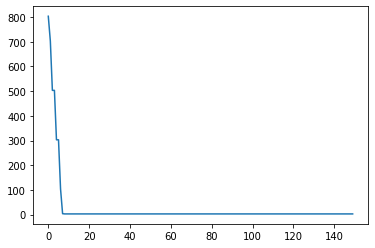

In [41]:
plt.plot(record)
plt.show()

In [42]:
print("Result : ", record[len(record) - 1] % 100)
print("Number of constraint violation :", int(record[len(record) - 1] / 100))

Result :  3
Number of constraint violation : 0
